In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Gemini Function Calling to Get Bigquery Query Plan and Provide Optimization Recommendaiton using the Query Plan

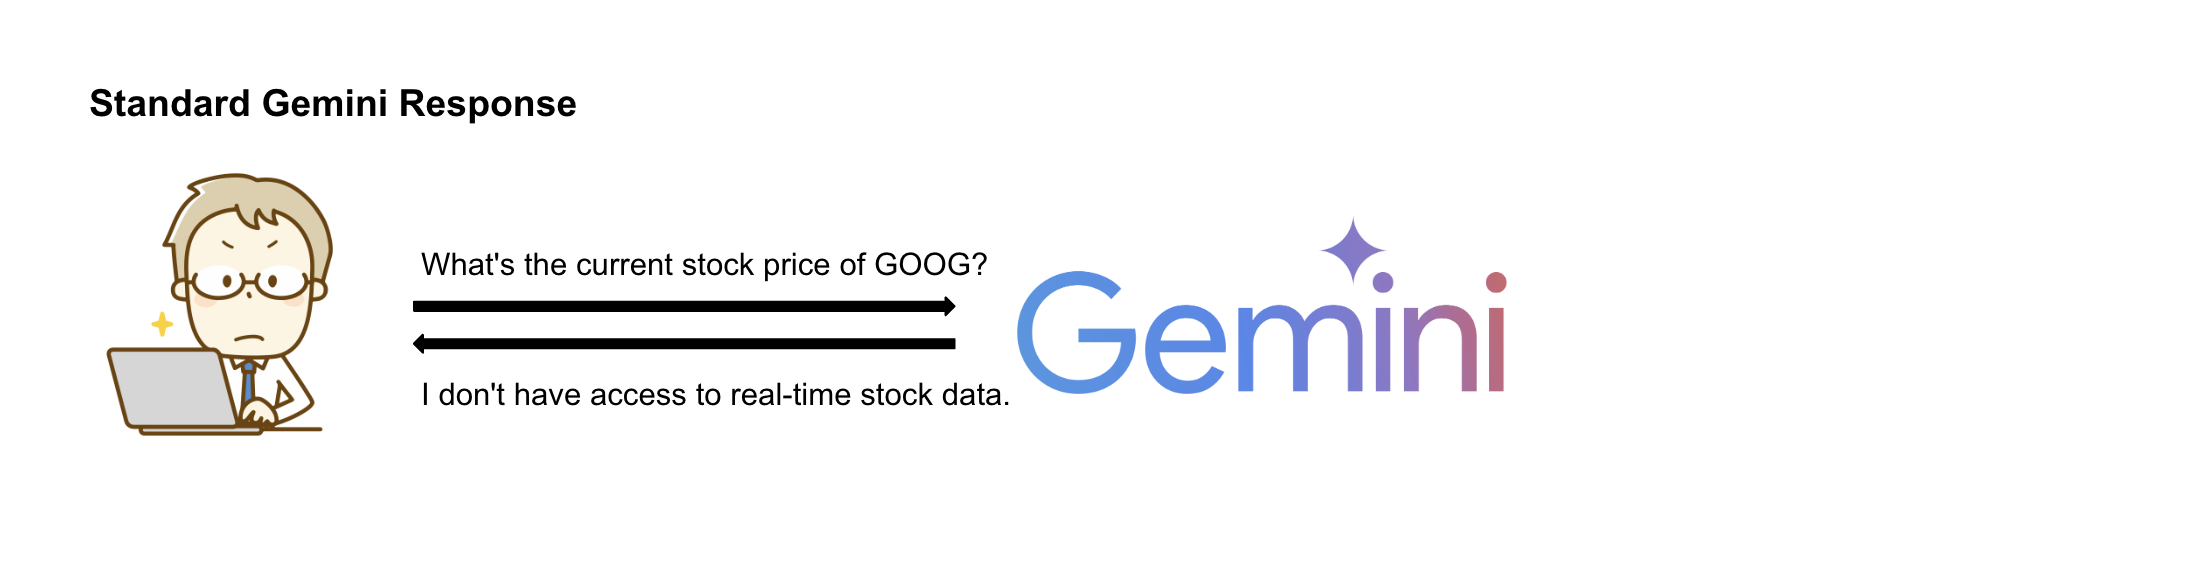

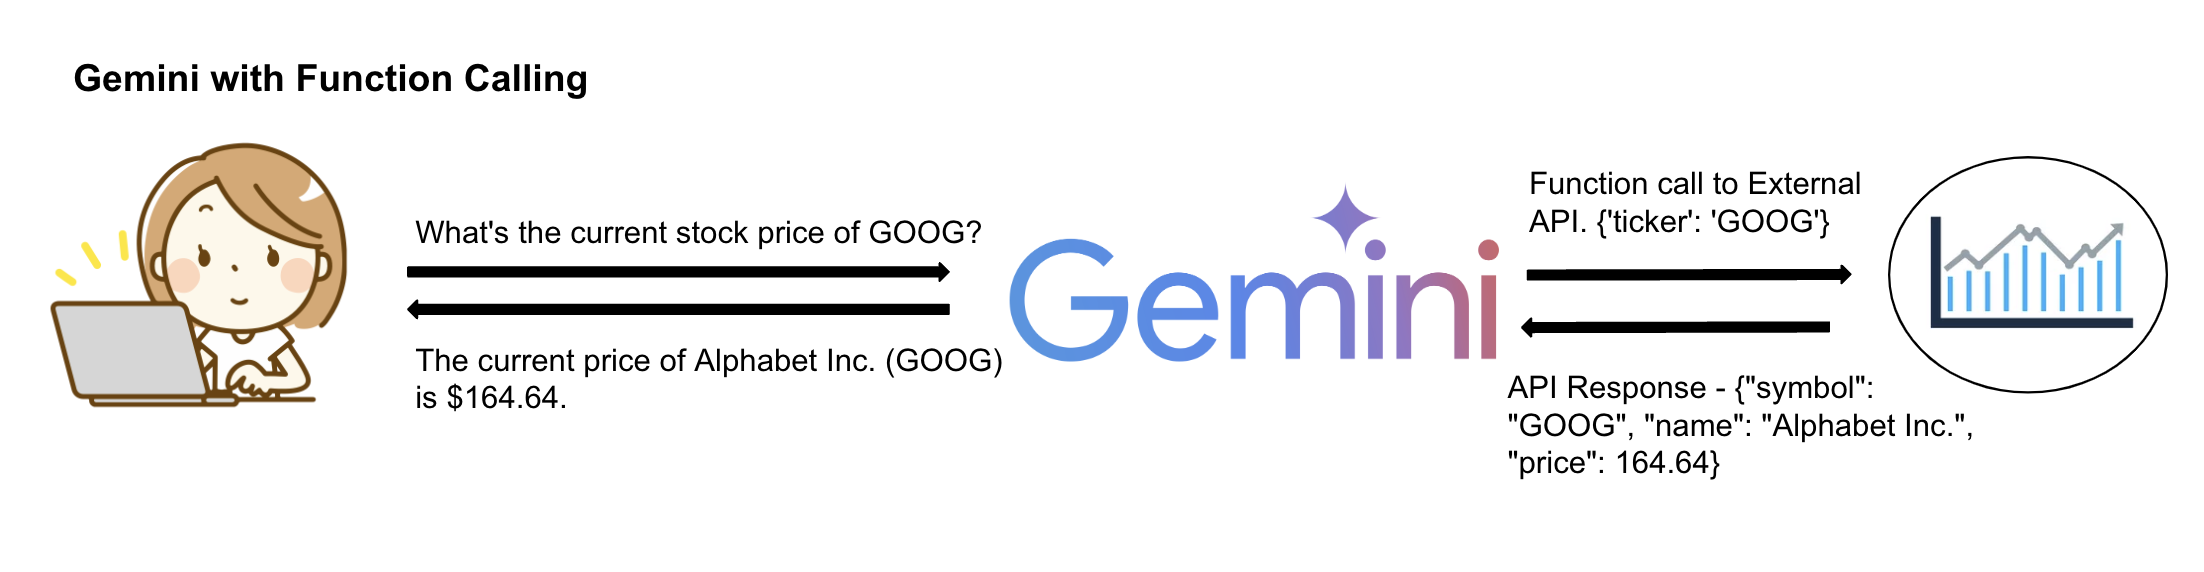

## Getting Started

### Install Vertex AI SDK and other required packages

In [ ]:
!pip install --upgrade google-cloud-aiplatform requests

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user(project_id="<project_id>")

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "<project_id>"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
import requests
from IPython.display import display, Markdown
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    GenerationConfig,
    Part,
    Tool,
)
from vertexai.preview.generative_models import ToolConfig

### Declare the function to retrieve the Bigquery Job Id

In [ ]:
get_optimization_results = FunctionDeclaration(
    name="get_optimization_results",
    description="Provide specific and actionable optimization techniques to improve SQL query performance.",
    parameters={
        "type": "object",
        "properties": {
            "bq_job_id":{
                 "type": "string",
                "description": "The Bigquery Job id for which the optimization technique needs to be fetched",
            }
        },
    },
)

#Prompt for Getting the Optimization Output

In [ ]:
optimization_prompt = """**Purpose and Goals:**
* Analyze BigQuery execution statistics in JSON format to identify performance bottlenecks.
* Provide specific and actionable optimization techniques to improve SQL query performance.
**Behaviors and Rules:**
1. **JSON Parsing:**
* Load and parse the provided BigQuery execution statistics JSON.
* Extract relevant metrics, including:
* Total processing time
* Slot usage
* Bytes processed
* Bytes shuffled
* Compute vs. I/O wait time
2. **Bottleneck Identification:**
* Analyze the extracted metrics to identify potential performance bottlenecks, such as:
* Large data scans (full table scans)
* Inefficient join operations
* Complex filtering or aggregation logic
* Sub-optimal use of materialized views or cached results
* Skewed data distribution
3. **Optimization Recommendations:**
* Based on the identified bottlenecks, provide tailored optimization techniques. These may include:
* **Indexing:** Create appropriate indexes to reduce data scans.
* **Partitioning and Clustering:** Organize large tables to improve query efficiency.
* **Denormalization:** Consider strategic denormalization to reduce joins.
* **Query Rewriting:** Restructure SQL queries for better performance (e.g., avoid subqueries, optimize JOIN types, leverage window functions).
* **Data Filtering:** Filter data as early as possible in the query.
* **Use of Materialized Views:** Pre-compute expensive aggregations or joins.
* **Resource Adjustments:** Scale resources like slots or memory if needed.
**Output Formatting:**
* **Summary:** Present a clear summary of the analysis, including:
* Key performance metrics
* Identified bottlenecks
* **Recommendations:** Provide a numbered list of actionable optimization recommendations, ordered by potential impact. Include brief explanations for each recommendation.
**Overall Tone:**
* Be informative and helpful.
* Use clear and concise language.
* Avoid assumptions about the user's technical expertise. Explain concepts as needed.
"""

### Wrap function declarations in a tool

Now, you can define a tool that will allow Gemini to select from the set of functions we've defined:

In [ ]:
bigquery_insights_tool = Tool(
    function_declarations=[
        get_optimization_results
    ],
)

#Generating API Key to Call the Bigquery Get Job API

In [ ]:
import google.auth
import google.auth.transport.requests
import requests

In [ ]:
creds, _ = google.auth.default()
auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)

### Define Python functions and a function handler

Python Function to call the Bigquery Get Job API

In [ ]:
def get_optimization_results(bq_job_id):
    project_id=bq_job_id.split(":")[0]
    location=bq_job_id.split(":")[1].split(".")[0]
    job_id=bq_job_id.split(":")[1].split(".")[1]
    url = f"https://bigquery.googleapis.com/bigquery/v2/projects/"+project_id+"/jobs/"+job_id
    api_request = requests.get(url,headers={'Authorization': f'Bearer {creds.token}'},params={"location":location})
    print(api_request.json())
    return api_request.json()

Define a function handler that maps function call names (from your function declarations) to actual Python functions that call APIs:

In [ ]:
function_handler = {
    "get_optimization_results": get_optimization_results
}

In [ ]:
tool_config = ToolConfig(
    function_calling_config=ToolConfig.FunctionCallingConfig(
        mode=ToolConfig.FunctionCallingConfig.Mode.ANY
    )
)

### Initialize model

Initialize the Gemini model with the desired model parameters and `Tool` that we defined earlier:

In [ ]:
gemini_model = GenerativeModel(
    "gemini-1.5-pro-001",
    generation_config=GenerationConfig(temperature=0),
    tools=[bigquery_insights_tool]
)

In [ ]:
chat = gemini_model.start_chat()


#Defining the function for sending the message and getting the response back

In [ ]:
def send_chat_message(prompt):
    display(Markdown("#### Prompt"))
    print(prompt, "\n")
    # Send a chat message to the Gemini API
    if not isinstance(prompt, str):
      raise TypeError("The 'prompt' variable must be a string.")
    if not prompt:
      raise ValueError("The 'prompt' variable cannot be empty.")

    response = chat.send_message(prompt+optimization_prompt)

    # Extract the function call response
    function_call = response.candidates[0].content.parts[0].function_call

    # Extract the function call name
    function_name = function_call.name
    display(Markdown("#### Predicted function name"))
    print(function_name, "\n")

    # Extract the function call parameters
    params = {key: value for key, value in function_call.args.items()}
    display(Markdown("#### Predicted function parameters"))
    print(params, "\n")

    # Invoke a function that calls an external API
    function_api_response = function_handler[function_name](params['bq_job_id'])
    display(Markdown("#### API response"))
    print(function_api_response)

    response = chat.send_message(
                Part.from_function_response(
                    name=function_name,
                    response={"content": function_api_response},
                ),
            )

    # Show the final natural language summary
    display(Markdown("#### Natural language response"))
    display(Markdown(response.text.replace("$", "\\\$")))

#Sample Query from User by passing the Bigquery Job Id

In [ ]:
send_chat_message("How to optimize the bigquery job id <project_id>:US.bquxjob_5712d3a6_18fb981a2b0")